# OpenAI Frozen Lake v0
We are attempting to solve the openai [frozen lake environment](https://gym.openai.com/envs/FrozenLake-v0) using reinforcement learning. Openai provides many environments for simulation.

Let us understand what reinforcement learning is and compare it with other available methodologies. The frozen lake problem involves a grid maze with a starting point and a goal. Along the way there are a few fatal pitfalls. Solving the frozen lake requires us to build an agent/bot who can traverse the maze and reach the goal without falling into the pitfalls. The duration of the travel is not a constraint but it is better if the bot can reach it quicker.

**SFFF       (S: starting point, safe)**<br>
**FHFH       (F: frozen surface, safe)**<br>
**FFFH       (H: hole, fall to your doom)**<br>
**HFFG       (G: goal, where the frisbee is located)**<br>

The frozen lake can be solved using a multitude of ways with standard graph search algos to optimization algorithms. There is one caveat though, the environment adds a small complexity to the mix. If our bot wanted to move right, there is a slight chance the bot may move in a random direction. *Apparently a gust of wind pushes us away* This complexity tends to break our algos like graph search etc which may not handle random probabilities. One worthy method to solve this dynamic environment is **Reinforcement Learning**.

## Framework
we will use the openai gym module to train our bot. Our bot will be a neural network and we will use keras and tensorflow for implementation. We will use Q learning which is a technique of RL(Reinforcement Learning).


In [20]:
import gym
import tensorflow as tf
from collections import deque
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from gym import wrappers
import shutil

In [21]:
shutil.rmtree('./monitor')
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env,'./monitor')

[2017-07-16 15:00:00,373] Making new env: FrozenLake-v0
[2017-07-16 15:00:00,373] Creating monitor directory ./monitor


In [22]:
print(env.observation_space.n)
print(env.action_space.n)

16
4


## Sample Simulation

The frozen lake environment has the following important entities; 
* **State**: A state denotes the current nature of the environment. For frozen lake there are 16 states, each corresponding to a single step. 
* **Action**: An action denotes a decision that can be taken by an agent in any state. For frozen lake there are 4 possible actions that can be take in any state; up, down, left and right provided there is a possibility
* **Reward**: A reward signifies the result of an action at a particular state. In frozen lake the reward is 1 if we reach the goal and 0 if we fail. The openai doesn't provide any reward for each action or falling into a hole.
* **Done**: Done signifies the end state of a simulation. For frozen lake, if a bot reaches the goal or falls into a hole, Done returns a value of True, else False. 

Below is an example of a single simulation episode. 

In [31]:
state = env.reset()
for i in range(10):
    env.render()
    action = env.action_space.sample()
    next_state, reward, done, prob = env.step(action)
    print('state:{} action:{} next_state:{} reward:{} done:{}'.format(state, action, next_state, reward, done))
    state = next_state
    if done:
        break


SFFF
FHFH
FFFH
HFFG
state:0 action:3 next_state:1 reward:0.0 done:False
  (Up)
SFFF
FHFH
FFFH
HFFG
state:1 action:2 next_state:1 reward:0.0 done:False
  (Right)
SFFF
FHFH
FFFH
HFFG
state:1 action:0 next_state:0 reward:0.0 done:False
  (Left)
SFFF
FHFH
FFFH
HFFG
state:0 action:1 next_state:1 reward:0.0 done:False
  (Down)
SFFF
FHFH
FFFH
HFFG
state:1 action:3 next_state:2 reward:0.0 done:False
  (Up)
SFFF
FHFH
FFFH
HFFG
state:2 action:0 next_state:2 reward:0.0 done:False
  (Left)
SFFF
FHFH
FFFH
HFFG
state:2 action:1 next_state:3 reward:0.0 done:False
  (Down)
SFFF
FHFH
FFFH
HFFG
state:3 action:3 next_state:2 reward:0.0 done:False
  (Up)
SFFF
FHFH
FFFH
HFFG
state:2 action:2 next_state:2 reward:0.0 done:False
  (Right)
SFFF
FHFH
FFFH
HFFG
state:2 action:2 next_state:3 reward:0.0 done:False


## Q Learning
Q-learning is one of the techniques used to implement RL. Q-learning relies on the [Bellman's equation](https://en.wikipedia.org/wiki/Bellman_equation). 

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

The Bellman equation provides a way to incorporate future rewards of an action to a current state. This is a core component of Q Learning. In a nutshell Q-learning is finding the function Q = f(state, action) which can be used to derive the action needed for a given state to traverse an environment.

The pseudo code for Q-learning is below

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

In [23]:
learning_rate = 0.001
memory_size = 2000

episodes = 5000
steps = 100
# changed from 0.95
gamma = 0.99

epsilon = 1
epsilon_stop = 0.01
epsilon_decay = 0.995
batch_size = 32

## The Learner
Our agent is a simple neural network with a [rectified linear](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) hidden layer and a linear output layer. We are using Adam optimizer. The neural network will be having a memory to store past experiences. This is known as [Temporal Difference Learning](https://en.wikipedia.org/wiki/Temporal_difference_learning).

In [24]:
bot = Sequential()
bot.add(Dense(10, input_dim=16, activation='relu'))
bot.add(Dense(4, activation='linear'))
bot.compile(loss='mse', optimizer = Adam(learning_rate))
memory = deque(maxlen=memory_size)

In [25]:
state_lkup = np.eye(env.observation_space.n)
action_lkup = np.eye(env.action_space.n)

In [26]:
reward_list=[]
state = env.reset()
for episode in range(episodes):
    total_reward = 0
    state = env.reset()
    for step in range(steps):
        if epsilon > np.random.rand():
            action = env.action_space.sample()
        else:
            action = np.argmax(bot.predict(np.reshape(state_lkup[state], (-1, env.observation_space.n))))
        next_state, reward, done, prob = env.step(action)
        if done and reward==0:
            reward = -1
        if not done and reward==0:
            reward = -0.02
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward = total_reward + reward
        if done:
            print('episode:{} steps:{} total reward:{} epsilon:{}'.format(episode + 1, step + 1, total_reward, epsilon))
            reward_list.append(total_reward)
            break
        
        minibatch = [memory[ii] for ii in np.random.choice(range(len(memory)), batch_size)]
        states = [each[0] for each in minibatch]
        actions = [each[1] for each in minibatch]
        rewards = [each[2] for each in minibatch]
        next_states = [each[3] for each in minibatch]
        dones = [each[4] for each in minibatch]
        
        next_states = np.reshape([state_lkup[state] for state in next_states], [-1,env.observation_space.n])
        states = np.reshape([state_lkup[state] for state in states], [-1,env.observation_space.n])
        actions = np.reshape(actions, (batch_size, 1))
        targetQs = bot.predict(next_states)
        episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
        targetQs[episode_ends] = (0, 0, 0, 0)
        
        targets = rewards + gamma * np.max(targetQs, axis=1)
        targets_f = bot.predict(states)
        
        for pos in range(len(actions)):
            targets_f[pos,actions[pos]] = targets[pos]
        
        bot.fit(states, targets_f, epochs=1, verbose=0)
    if epsilon > epsilon_stop:
        epsilon = epsilon * epsilon_decay

[2017-07-16 15:00:26,036] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000000.json
[2017-07-16 15:00:26,036] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000001.json


episode:1 steps:7 total reward:-1.12 epsilon:1
episode:2 steps:3 total reward:-1.04 epsilon:0.995
episode:3 steps:18 total reward:-1.34 epsilon:0.990025
episode:4 steps:6 total reward:-1.1 epsilon:0.985074875
episode:5 steps:8 total reward:-1.1400000000000001 epsilon:0.9801495006250001


[2017-07-16 15:00:27,069] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000008.json


episode:6 steps:11 total reward:-1.2 epsilon:0.9752487531218751
episode:7 steps:4 total reward:-1.06 epsilon:0.9703725093562657
episode:8 steps:20 total reward:0.6199999999999999 epsilon:0.9655206468094844
episode:9 steps:6 total reward:-1.1 epsilon:0.960693043575437
episode:10 steps:7 total reward:-1.12 epsilon:0.9558895783575597
episode:11 steps:3 total reward:-1.04 epsilon:0.9511101304657719
episode:12 steps:10 total reward:-1.18 epsilon:0.946354579813443
episode:13 steps:4 total reward:-1.06 epsilon:0.9416228069143757
episode:14 steps:2 total reward:-1.02 epsilon:0.9369146928798039
episode:15 steps:8 total reward:-1.1400000000000001 epsilon:0.9322301194154049
episode:16 steps:9 total reward:-1.16 epsilon:0.9275689688183278
episode:17 steps:10 total reward:-1.18 epsilon:0.9229311239742362
episode:18 steps:7 total reward:-1.12 epsilon:0.918316468354365
episode:19 steps:6 total reward:-1.1 epsilon:0.9137248860125932
episode:20 steps:2 total reward:-1.02 epsilon:0.9091562615825302
epis

[2017-07-16 15:00:27,934] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000027.json


episode:26 steps:12 total reward:-1.22 epsilon:0.8822202429488013
episode:27 steps:8 total reward:-1.1400000000000001 epsilon:0.8778091417340573
episode:28 steps:3 total reward:-1.04 epsilon:0.8734200960253871
episode:29 steps:5 total reward:-1.08 epsilon:0.8690529955452602
episode:30 steps:9 total reward:-1.16 epsilon:0.8647077305675338
episode:31 steps:3 total reward:-1.04 epsilon:0.8603841919146962
episode:32 steps:5 total reward:-1.08 epsilon:0.8560822709551227
episode:33 steps:8 total reward:-1.1400000000000001 epsilon:0.851801859600347
episode:34 steps:4 total reward:-1.06 epsilon:0.8475428503023453
episode:35 steps:7 total reward:-1.12 epsilon:0.8433051360508336
episode:36 steps:7 total reward:-1.12 epsilon:0.8390886103705794
episode:37 steps:2 total reward:-1.02 epsilon:0.8348931673187264
episode:38 steps:2 total reward:-1.02 epsilon:0.8307187014821328
episode:39 steps:2 total reward:-1.02 epsilon:0.8265651079747222
episode:40 steps:10 total reward:-1.18 epsilon:0.8224322824348

[2017-07-16 15:00:29,122] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000064.json


episode:54 steps:14 total reward:-1.26 epsilon:0.7666961448653229
episode:55 steps:5 total reward:-1.08 epsilon:0.7628626641409962
episode:56 steps:2 total reward:-1.02 epsilon:0.7590483508202912
episode:57 steps:2 total reward:-1.02 epsilon:0.7552531090661897
episode:58 steps:8 total reward:0.86 epsilon:0.7514768435208588
episode:59 steps:7 total reward:-1.12 epsilon:0.7477194593032545
episode:60 steps:2 total reward:-1.02 epsilon:0.7439808620067382
episode:61 steps:4 total reward:-1.06 epsilon:0.7402609576967045
episode:62 steps:2 total reward:-1.02 epsilon:0.736559652908221
episode:63 steps:7 total reward:-1.12 epsilon:0.7328768546436799
episode:64 steps:3 total reward:-1.04 epsilon:0.7292124703704616
episode:65 steps:7 total reward:-1.12 epsilon:0.7255664080186093
episode:66 steps:17 total reward:-1.32 epsilon:0.7219385759785162
episode:67 steps:2 total reward:-1.02 epsilon:0.7183288830986236
episode:68 steps:3 total reward:-1.04 epsilon:0.7147372386831305
episode:69 steps:5 total 

[2017-07-16 15:00:31,606] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000125.json


episode:119 steps:10 total reward:-1.18 epsilon:0.5535075230322891
episode:120 steps:2 total reward:-1.02 epsilon:0.5507399854171277
episode:121 steps:2 total reward:-1.02 epsilon:0.547986285490042
episode:122 steps:12 total reward:-1.22 epsilon:0.5452463540625918
episode:123 steps:4 total reward:-1.06 epsilon:0.5425201222922789
episode:124 steps:2 total reward:-1.02 epsilon:0.5398075216808175
episode:125 steps:19 total reward:-1.36 epsilon:0.5371084840724134
episode:126 steps:4 total reward:-1.06 epsilon:0.5344229416520513
episode:127 steps:2 total reward:-1.02 epsilon:0.531750826943791
episode:128 steps:14 total reward:-1.26 epsilon:0.5290920728090721
episode:129 steps:6 total reward:-1.1 epsilon:0.5264466124450268
episode:130 steps:8 total reward:-1.1400000000000001 epsilon:0.5238143793828016
episode:131 steps:3 total reward:-1.04 epsilon:0.5211953074858876
episode:132 steps:15 total reward:-1.28 epsilon:0.5185893309484582
episode:133 steps:21 total reward:-1.4000000000000001 epsilo

[2017-07-16 15:00:38,638] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000216.json


episode:213 steps:16 total reward:-1.3 epsilon:0.3455358541129786
episode:214 steps:13 total reward:-1.24 epsilon:0.3438081748424137
episode:215 steps:13 total reward:-1.24 epsilon:0.3420891339682016
episode:216 steps:19 total reward:-1.36 epsilon:0.3403786882983606
episode:217 steps:7 total reward:-1.12 epsilon:0.3386767948568688
episode:218 steps:10 total reward:-1.18 epsilon:0.33698341088258443
episode:219 steps:12 total reward:-1.22 epsilon:0.3352984938281715
episode:220 steps:6 total reward:-1.1 epsilon:0.33362200135903064
episode:221 steps:25 total reward:-1.4800000000000002 epsilon:0.33195389135223546
episode:222 steps:14 total reward:-1.26 epsilon:0.3302941218954743
episode:223 steps:5 total reward:-1.08 epsilon:0.32864265128599696
episode:224 steps:15 total reward:-1.28 epsilon:0.326999438029567
episode:225 steps:22 total reward:0.5799999999999998 epsilon:0.3253644408394192
episode:226 steps:18 total reward:-1.34 epsilon:0.3237376186352221
episode:227 steps:23 total reward:-1.

[2017-07-16 15:00:50,977] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000343.json


episode:341 steps:10 total reward:-1.18 epsilon:0.18190617987607657
episode:342 steps:10 total reward:-1.18 epsilon:0.18099664897669618
episode:343 steps:3 total reward:-1.04 epsilon:0.1800916657318127
episode:344 steps:33 total reward:-1.6400000000000001 epsilon:0.17919120740315364
episode:345 steps:23 total reward:-1.4400000000000002 epsilon:0.17829525136613786
episode:346 steps:27 total reward:-1.52 epsilon:0.17740377510930716
episode:347 steps:8 total reward:-1.1400000000000001 epsilon:0.17651675623376062
episode:348 steps:31 total reward:-1.6 epsilon:0.1756341724525918
episode:349 steps:18 total reward:-1.34 epsilon:0.17475600159032884
episode:350 steps:13 total reward:-1.24 epsilon:0.17388222158237718
episode:351 steps:15 total reward:-1.28 epsilon:0.1730128104744653
episode:352 steps:43 total reward:0.1599999999999996 epsilon:0.17214774642209296
episode:353 steps:41 total reward:-1.8000000000000003 epsilon:0.1712870076899825
episode:354 steps:12 total reward:-1.22 epsilon:0.1704

[2017-07-16 15:01:12,240] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000512.json


episode:510 steps:29 total reward:0.43999999999999984 epsilon:0.07797369223798889
episode:511 steps:10 total reward:-1.18 epsilon:0.07758382377679894
episode:512 steps:7 total reward:-1.12 epsilon:0.07719590465791494
episode:513 steps:10 total reward:0.8200000000000001 epsilon:0.07680992513462537
episode:514 steps:46 total reward:-1.9000000000000004 epsilon:0.07642587550895225
episode:515 steps:20 total reward:0.6199999999999999 epsilon:0.07604374613140748
episode:516 steps:36 total reward:0.2999999999999997 epsilon:0.07566352740075044
episode:517 steps:26 total reward:-1.5 epsilon:0.07528520976374668
episode:518 steps:13 total reward:0.76 epsilon:0.07490878371492794
episode:519 steps:25 total reward:-1.4800000000000002 epsilon:0.0745342397963533
episode:520 steps:18 total reward:0.6599999999999999 epsilon:0.07416156859737154
episode:521 steps:19 total reward:-1.36 epsilon:0.07379076075438468
episode:522 steps:7 total reward:-1.12 epsilon:0.07342180695061275
episode:523 steps:32 total 

[2017-07-16 15:01:42,927] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video000729.json


episode:728 steps:22 total reward:-1.4200000000000002 epsilon:0.026144461565619025
episode:729 steps:30 total reward:-1.58 epsilon:0.02601373925779093
episode:730 steps:15 total reward:-1.28 epsilon:0.025883670561501974
episode:731 steps:31 total reward:0.3999999999999998 epsilon:0.025754252208694463
episode:732 steps:24 total reward:0.5399999999999998 epsilon:0.02562548094765099
episode:733 steps:8 total reward:-1.1400000000000001 epsilon:0.025497353542912736
episode:734 steps:32 total reward:-1.62 epsilon:0.02536986677519817
episode:735 steps:13 total reward:-1.24 epsilon:0.02524301744132218
episode:736 steps:9 total reward:-1.16 epsilon:0.025116802354115567
episode:737 steps:16 total reward:-1.3 epsilon:0.024991218342344988
episode:738 steps:16 total reward:-1.3 epsilon:0.024866262250633264
episode:739 steps:9 total reward:0.84 epsilon:0.024741930939380097
episode:740 steps:15 total reward:0.72 epsilon:0.024618221284683196
episode:741 steps:9 total reward:0.84 epsilon:0.024495130178

[2017-07-16 15:02:30,121] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video001000.json


episode:999 steps:47 total reward:0.07999999999999952 epsilon:0.00998645168764533
episode:1000 steps:47 total reward:-1.9200000000000004 epsilon:0.00998645168764533
episode:1001 steps:18 total reward:-1.34 epsilon:0.00998645168764533
episode:1002 steps:51 total reward:-4.440892098500626e-16 epsilon:0.00998645168764533
episode:1003 steps:11 total reward:-1.2 epsilon:0.00998645168764533
episode:1004 steps:44 total reward:0.13999999999999957 epsilon:0.00998645168764533
episode:1005 steps:23 total reward:-1.4400000000000002 epsilon:0.00998645168764533
episode:1006 steps:25 total reward:-1.4800000000000002 epsilon:0.00998645168764533
episode:1007 steps:9 total reward:-1.16 epsilon:0.00998645168764533
episode:1008 steps:49 total reward:-1.9600000000000004 epsilon:0.00998645168764533
episode:1009 steps:23 total reward:0.5599999999999998 epsilon:0.00998645168764533
episode:1010 steps:20 total reward:-1.3800000000000001 epsilon:0.00998645168764533
episode:1011 steps:25 total reward:-1.480000000

[2017-07-16 15:06:31,041] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video002000.json


episode:1999 steps:35 total reward:0.31999999999999973 epsilon:0.00998645168764533
episode:2000 steps:7 total reward:-1.12 epsilon:0.00998645168764533
episode:2001 steps:7 total reward:0.88 epsilon:0.00998645168764533
episode:2002 steps:19 total reward:-1.36 epsilon:0.00998645168764533
episode:2003 steps:43 total reward:-1.8400000000000003 epsilon:0.00998645168764533
episode:2004 steps:57 total reward:-0.12000000000000055 epsilon:0.00998645168764533
episode:2005 steps:97 total reward:-0.9200000000000013 epsilon:0.00998645168764533
episode:2006 steps:47 total reward:0.07999999999999952 epsilon:0.00998645168764533
episode:2007 steps:81 total reward:-0.600000000000001 epsilon:0.00998645168764533
episode:2008 steps:20 total reward:0.6199999999999999 epsilon:0.00998645168764533
episode:2009 steps:21 total reward:0.5999999999999999 epsilon:0.00998645168764533
episode:2010 steps:11 total reward:0.8 epsilon:0.00998645168764533
episode:2011 steps:100 total reward:-2.9800000000000013 epsilon:0.0

[2017-07-16 15:10:48,683] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video003000.json


episode:2999 steps:38 total reward:-1.7400000000000002 epsilon:0.00998645168764533
episode:3000 steps:29 total reward:-1.56 epsilon:0.00998645168764533
episode:3001 steps:38 total reward:-1.7400000000000002 epsilon:0.00998645168764533
episode:3002 steps:21 total reward:-1.4000000000000001 epsilon:0.00998645168764533
episode:3003 steps:100 total reward:-2.9800000000000013 epsilon:0.00998645168764533
episode:3004 steps:23 total reward:0.5599999999999998 epsilon:0.00998645168764533
episode:3005 steps:31 total reward:0.3999999999999998 epsilon:0.00998645168764533
episode:3006 steps:33 total reward:0.35999999999999976 epsilon:0.00998645168764533
episode:3007 steps:42 total reward:0.1799999999999996 epsilon:0.00998645168764533
episode:3008 steps:85 total reward:-2.680000000000001 epsilon:0.00998645168764533
episode:3009 steps:44 total reward:0.13999999999999957 epsilon:0.00998645168764533
episode:3010 steps:8 total reward:0.86 epsilon:0.00998645168764533
episode:3011 steps:37 total reward:0.

[2017-07-16 15:15:05,725] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video004000.json


episode:3998 steps:50 total reward:0.019999999999999463 epsilon:0.00998645168764533
episode:3999 steps:20 total reward:0.6199999999999999 epsilon:0.00998645168764533
episode:4000 steps:12 total reward:-1.22 epsilon:0.00998645168764533
episode:4001 steps:58 total reward:-0.14000000000000057 epsilon:0.00998645168764533
episode:4002 steps:57 total reward:-0.12000000000000055 epsilon:0.00998645168764533
episode:4003 steps:97 total reward:-0.9200000000000013 epsilon:0.00998645168764533
episode:4004 steps:20 total reward:0.6199999999999999 epsilon:0.00998645168764533
episode:4005 steps:100 total reward:-2.9800000000000013 epsilon:0.00998645168764533
episode:4006 steps:100 total reward:-2.9800000000000013 epsilon:0.00998645168764533
episode:4007 steps:32 total reward:0.3799999999999998 epsilon:0.00998645168764533
episode:4008 steps:19 total reward:-1.36 epsilon:0.00998645168764533
episode:4009 steps:11 total reward:0.8 epsilon:0.00998645168764533
episode:4010 steps:100 total reward:-2.9800000

[2017-07-16 15:19:37,935] Starting new video recorder writing to C:\Users\Abdul\Documents\My Projects\Deep learning nano degree\my-experiments\reinforcement learning\monitor\openaigym.video.2.12772.video005000.json


episode:4998 steps:36 total reward:0.2999999999999997 epsilon:0.00998645168764533
episode:4999 steps:23 total reward:0.5599999999999998 epsilon:0.00998645168764533
episode:5000 steps:37 total reward:0.2799999999999997 epsilon:0.00998645168764533


## Performance
After running the simulation for around 5000 episodes and plotting the rewards per iteration, we can notice that the rewards increase over time.

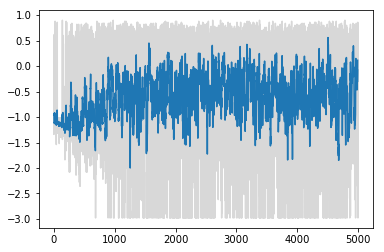

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline 

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

smoothed_rews = running_mean(reward_list, 10)

plt.plot(reward_list, color='grey', alpha=0.3)
plt.plot(smoothed_rews)

## Submission to OpenAI
This submission solves the environment around the 2.3K episodes. 

In [29]:
env.close()
gym.upload('./monitor', api_key='')

[2017-07-16 15:20:32,132] [FrozenLake-v0] Uploading 5000 episodes of training data
[2017-07-16 15:20:35,422] [FrozenLake-v0] Uploading videos of 15 training episodes (1706 bytes)
[2017-07-16 15:20:36,031] [FrozenLake-v0] Creating evaluation object from ./monitor with learning curve and training video
[2017-07-16 15:20:36,641] 
****************************************************
You successfully uploaded your evaluation on FrozenLake-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_i7IBk5tTPOFM0a714aFrg

****************************************************
